In [2]:
import os
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
import pyAgrum.lib.dynamicBN as gdyn
from asgiref.sync import sync_to_async, async_to_sync
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"

In [3]:
def code_as_number(code):
    return sum(ord(s) for s in code)

In [4]:
def add_arc(twodbn, parent, child):
    twodbn.addArc(parent, child)

In [5]:
def add_node(twodbn, code):
    twodbn.add(
        gum.LabelizedVariable(
            code,
            code,
            2
        ),
        code_as_number(code)
    )

In [6]:
course = Course.objects.get(id=1)
network = course.network
network_subjects = network.subjects.all()
twodbn = gum.BayesNet()

In [7]:
a = network_subjects[0]
p = a.probabilities.get()
p.subjects_probabilities
# p.evidences_probabilities

[{'code': 'ca0', 'values': [0.5, 0.5]},
 {'code': 'cat',
  'relations': [{'codes': [{'code': 'ca0', 'status': True}],
    'values': [0.999, 0.001]},
   {'codes': [{'code': 'ca0', 'status': False}], 'values': [0.001, 0.999]}]}]

In [8]:
for network_subject in network_subjects:

    evidences = network_subject.evidences.all()
    subject = network_subject.subject

    add_node(twodbn, f'{subject.code}0')
    add_node(twodbn, f'{subject.code}t')

    for evidence in evidences:

        add_node(twodbn, f'{evidence.code}0')
        add_node(twodbn, f'{evidence.code}t')

In [9]:
for network_subject in network_subjects:

    evidences = network_subject.evidences.all()
    parent_subjects = network_subject.network_subjects.all()
    subject = network_subject.subject

    subjec_code0 = f'{subject.code}0'
    subjec_codet = f'{subject.code}t'

    add_arc(twodbn, subjec_code0, subjec_codet)

    for parent_subject in parent_subjects:

        parent_subjec_code0 = f'{parent_subject.code}0'
        parent_subjec_codet = f'{parent_subject.code}t'

        add_arc(twodbn, parent_subjec_code0, subjec_code0)
        add_arc(twodbn, parent_subjec_codet, subjec_codet)

    for evidence in evidences:

        add_arc(twodbn, subjec_code0, f'{evidence.code}0')
        add_arc(twodbn, subjec_codet, f'{evidence.code}t')

In [10]:
for network_subject in network_subjects:
    
    probabilities = network_subject.probabilities.get()
    
    subjects_probabilities = probabilities.subjects_probabilities
    for probability in subjects_probabilities:
        if 'relations' in probability:
            for relation in probability['relations']:
                condition = {code['code']: int(code['status']) for code in relation['codes']}
                twodbn.cpt(probability['code'])[condition] = relation['values']
        else:
            twodbn.cpt(probability['code']).fillWith(probability['values'])
            
    evidences_probabilities = probabilities.evidences_probabilities
    for probability in evidences_probabilities:
        if 'relations' in probability:
            for relation in probability['relations']:
                condition = {code['code']: int(code['status']) for code in relation['codes']}
                twodbn.cpt(probability['code'])[condition] = relation['values']
        else:
            twodbn.cpt(probability['code']).fillWith(probability['values'])

In [11]:
twodbn.cpt('cat')

(gum::Potential<double>@0x558f2d08c9e0) <cat:0|ca0:0> :: 0.001 /<cat:1|ca0:0> :: 0.999 /<cat:0|ca0:1> :: 0.999 /<cat:1|ca0:1> :: 0.001

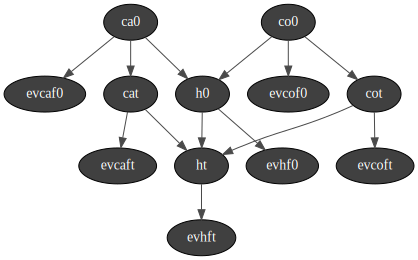

In [12]:
gnb.showBN(twodbn, size="20")

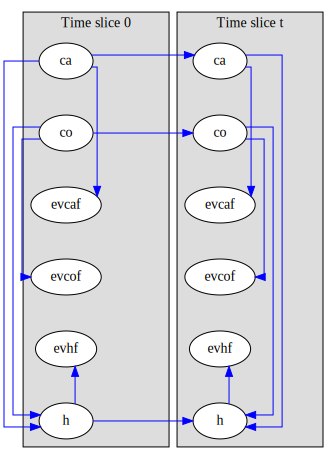

In [13]:
gdyn.showTimeSlices(twodbn, size="20")

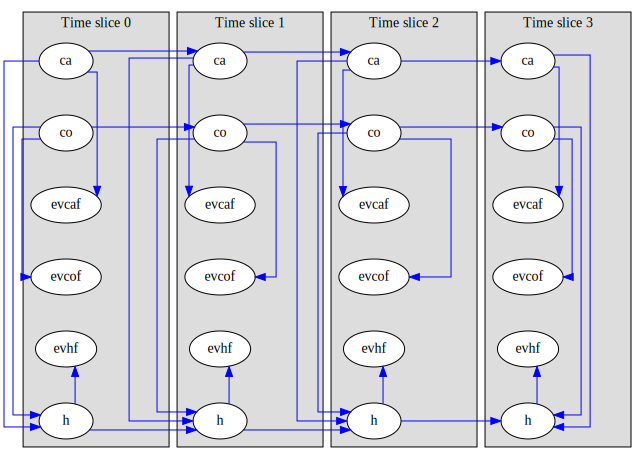

In [14]:
T = course.questions.count()

dbn = gdyn.unroll2TBN(twodbn, T)
gdyn.showTimeSlices(dbn, size="20")

In [15]:
ie = gum.VariableElimination(dbn)
ie.setEvidence({'evcaf0': 1, 'evhf0': 1})
ie.makeInference()
ie.posterior('ca0')

(gum::Potential<double>@0x558f2dbe4390) <ca0:0> :: 0.114382 /<ca0:1> :: 0.885618

In [16]:
from its.apps.its.dbn import DBNModel

In [17]:
dbn_model = DBNModel(network=course.network)

In [18]:
a = course.network.subjects.all()

In [22]:
b = a[0]
b

<NetworkSubject: 1 - DBN Versão 1 - Cateto Adjacente>

In [23]:
dbn_model

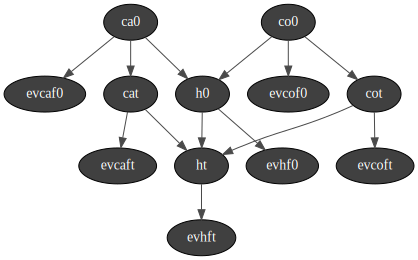

In [24]:
gnb.showBN(dbn_model.twodbn, size="20")

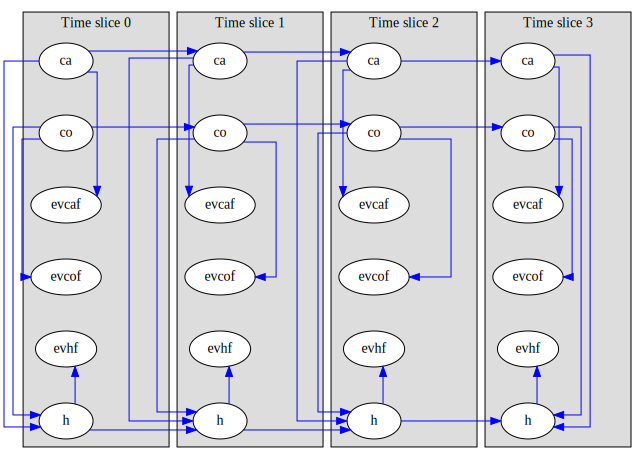

In [25]:
T = course.questions.count()

dbn = gdyn.unroll2TBN(dbn_model.twodbn, T)
gdyn.showTimeSlices(dbn, size="20")

In [27]:
dbn_model.twodbn.cpt('ht')

(gum::Potential<double>@0x558f2d9517c0) <ht:0|h0:0|cat:0|cot:0> :: 0.999 /<ht:1|h0:0|cat:0|cot:0> :: 0.001 /<ht:0|h0:1|cat:0|cot:0> :: 0.9 /<ht:1|h0:1|cat:0|cot:0> :: 0.1 /<ht:0|h0:0|cat:1|cot:0> :: 0.8 /<ht:1|h0:0|cat:1|cot:0> :: 0.2 /<ht:0|h0:1|cat:1|cot:0> :: 0.1 /<ht:1|h0:1|cat:1|cot:0> :: 0.9 /<ht:0|h0:0|cat:0|cot:1> :: 0.8 /<ht:1|h0:0|cat:0|cot:1> :: 0.2 /<ht:0|h0:1|cat:0|cot:1> :: 0.1 /<ht:1|h0:1|cat:0|cot:1> :: 0.9 /<ht:0|h0:0|cat:1|cot:1> :: 0.1 /<ht:1|h0:0|cat:1|cot:1> :: 0.9 /<ht:0|h0:1|cat:1|cot:1> :: 0.001 /<ht:1|h0:1|cat:1|cot:1> :: 0.999